In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys

sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [2]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,[1.9371510e-07 1.2311488e-02 1.1168750e-02 ......,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,[2.4959445e-07 1.2348385e-02 1.0678725e-02 ......,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,[1.1920929e-07 1.2154797e-02 1.6620804e-02 ......,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056


In [3]:
file_path = os.path.join(TS_PREPROC_FOLDER, f'{TRACES}.npy')
traces = np.load(file_path, allow_pickle=True)

traces.shape

(2452, 27, 27)

# RGB format

In [4]:
# array of empty RGB matrixes
rgb_traces = np.zeros((len(traces), traces.shape[1], traces.shape[2], 3), dtype=np.float32)

for i in range(len(traces)):
    trace = traces[i]

    min_value = np.min(trace)
    max_value = np.max(trace)
    normalized_trace = (trace - min_value) / (max_value - min_value)

    red_channel = normalized_trace
    green_channel = np.zeros_like(normalized_trace)
    blue_channel = np.zeros_like(normalized_trace)

    rgb_trace = np.dstack((red_channel, green_channel, blue_channel))
    rgb_traces[i] = rgb_trace


rgb_traces.shape

(2452, 27, 27, 3)

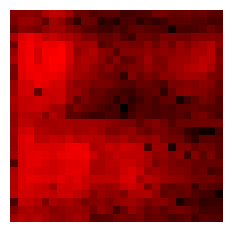

In [5]:
image = rgb_traces[0]

plt.imshow(image)
plt.axis('off')
plt.show()

# Training, Validation and Test Sets Preparation

In [6]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

rgb_traces = rgb_traces[sorted_indices]

rgb_traces

array([[[[0.520202  , 0.        , 0.        ],
         [0.5271942 , 0.        , 0.        ],
         [0.54677725, 0.        , 0.        ],
         ...,
         [0.42110288, 0.        , 0.        ],
         [0.3612241 , 0.        , 0.        ],
         [0.33273795, 0.        , 0.        ]],

        [[0.48784044, 0.        , 0.        ],
         [0.5939264 , 0.        , 0.        ],
         [0.6059518 , 0.        , 0.        ],
         ...,
         [0.3325991 , 0.        , 0.        ],
         [0.2731964 , 0.        , 0.        ],
         [0.29290196, 0.        , 0.        ]],

        [[0.38887653, 0.        , 0.        ],
         [0.53804153, 0.        , 0.        ],
         [0.51099825, 0.        , 0.        ],
         ...,
         [0.33840528, 0.        , 0.        ],
         [0.4223887 , 0.        , 0.        ],
         [0.34501615, 0.        , 0.        ]],

        ...,

        [[0.30227807, 0.        , 0.        ],
         [0.76247066, 0.        , 0.        ]

In [7]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = rgb_traces[:split_index]
X_test = rgb_traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_valid.shape, X_test.shape, y_train_v.shape, y_valid.shape, y_test.shape

((1462, 27, 27, 3),
 (366, 27, 27, 3),
 (624, 27, 27, 3),
 (1462,),
 (366,),
 (624,))

# CNN

In [8]:
from keras.src.layers import Conv2D, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Dense
from keras import Sequential


def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=(5, 5), **kwargs):

    model = Sequential()

    model.add(Conv2D(filters=filters,
                     kernel_size=(kernel_size, kernel_size),
                     activation='relu',
                     #input_shape=input_shape,
                     padding='same'
                     ))

    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for _ in range(n_conv):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling2D())

    for _ in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [9]:
import optuna
from sklearn.metrics import accuracy_score

# objective function to be minimized
def objective_fun(trial):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)

    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")

    cnn = build_model(X_train_v.shape[1:], len(np.unique(y_train_v)),
                      n_hidden=n_hidden,
                      hidden_nodes=hidden_nodes,
                      n_conv=n_conv,
                      dropout=dropout,
                      filters=filters,
                      kernel_size=kernel_size,
                      )

    cnn.fit(X_train_v, y_train_v, batch_size=batch_size, epochs=epochs, verbose=False)

    y_pred = np.argmax(cnn.predict(X_valid), axis=1)

    error = accuracy_score(y_valid, y_pred)

    return error


study = optuna.create_study(direction='maximize')
study.optimize(objective_fun, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-29 10:54:36,463] A new study created in memory with name: no-name-f871619f-1485-46a3-8a2f-495c7b119d95


Running little bitch having n_conv=0, dropout=0.19990906466186828, hidden_nodes=239
Running little bitch having n_conv=3, dropout=0.07981892756125755, hidden_nodes=87
Running little bitch having n_conv=3, dropout=0.10383356319325183, hidden_nodes=135
Running little bitch having n_conv=2, dropout=0.07762550549241512, hidden_nodes=205
Running little bitch having n_conv=0, dropout=0.06127228468015975, hidden_nodes=94
Running little bitch having n_conv=3, dropout=0.006355316330203898, hidden_nodes=114
Running little bitch having n_conv=3, dropout=0.022464904219810955, hidden_nodes=94
Running little bitch having n_conv=0, dropout=0.09769848263370116, hidden_nodes=77


2023-06-29 10:54:37.769059: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to int64 is not supported
2023-06-29 10:54:37.923864: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to int64 is not supported
2023-06-29 10:54:38.046776: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported
2023-06-29 10:54:38.315336: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported
2023-06-29 10:54:38.448453: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported
2023-06-29 10:54:38.464115: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supporte

UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/threading.py", line 930, in _bootstrap
      self._bootstrap_inner()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
      self.run()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/threading.py", line 910, in run
      self._target(*self._args, **self._kwargs)
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/concurrent/futures/thread.py", line 77, in _worker
      work_item.run()
    File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/concurrent/futures/thread.py", line 52, in run
      result = self.fn(*self.args, **self.kwargs)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
      frozen_trial = _run_trial(study, func, catch)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
      value_or_values = func(trial)
    File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_86036/2462299479.py", line 27, in objective_fun
      cnn.fit(X_train_v, y_train_v, batch_size=batch_size, epochs=epochs, verbose=False)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1085, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/keras/src/metrics/base_metric.py", line 708, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_9727]

In [ ]:
best_params = study.best_params
best_params

In [ ]:
cnn = build_model(X_train.shape[1:], 2, **best_params)
cnn.summary()

In [ ]:
cnn.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

In [ ]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

predictions = cnn.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# LIME

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

